# Data

## Load the data

In [126]:
"""
    Download and save raw market data CSV
"""

import pandas as pd
import logging
import os

# Setup Logger
logging.basicConfig(level=logging.INFO, format="%(asctime)s | %(levelname)s | %(message)s", handlers=[logging.StreamHandler()])
logger = logging.getLogger(__name__)

# Download and save CSV. One time only
logger.info("Downloading power data...")
url = "https://data.open-power-system-data.org/time_series/2020-10-06/time_series_60min_singleindex.csv"

df = pd.read_csv(url)
logger.info("Saving to data/power_data_raw.csv")
os.makedirs("data", exist_ok=True)
df.to_csv("data/power_data_raw.csv", index=False)

logger.info("Process completed.")

2025-11-20 21:02:12,419 | INFO | Downloading power data...
2025-11-20 21:02:18,341 | INFO | Saving to data/power_data_raw.csv
2025-11-20 21:02:21,782 | INFO | Process completed.


## Get Austria's Values

In [127]:
df = pd.read_csv("data/power_data_raw.csv")
print(df.head())
with open("data/all_column_names.txt", "w") as f:
    for col in df.columns:
        f.write(f"{col}\n")

          utc_timestamp        cet_cest_timestamp  \
0  2014-12-31T23:00:00Z  2015-01-01T00:00:00+0100   
1  2015-01-01T00:00:00Z  2015-01-01T01:00:00+0100   
2  2015-01-01T01:00:00Z  2015-01-01T02:00:00+0100   
3  2015-01-01T02:00:00Z  2015-01-01T03:00:00+0100   
4  2015-01-01T03:00:00Z  2015-01-01T04:00:00+0100   

   AT_load_actual_entsoe_transparency  AT_load_forecast_entsoe_transparency  \
0                                 NaN                                   NaN   
1                              5946.0                                6701.0   
2                              5726.0                                6593.0   
3                              5347.0                                6482.0   
4                              5249.0                                6454.0   

   AT_price_day_ahead  AT_solar_generation_actual  \
0                 NaN                         NaN   
1                35.0                         NaN   
2                45.0                         N

In [128]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50401 entries, 0 to 50400
Columns: 300 entries, utc_timestamp to UA_load_forecast_entsoe_transparency
dtypes: float64(298), object(2)
memory usage: 115.4+ MB


In [129]:
at_cols = df.columns[df.columns.str.startswith("AT_")]
selected_cols = ["utc_timestamp"] + list(at_cols) # Desired Columns
df_selected = df[selected_cols].copy()
df_selected = df_selected.drop(["AT_load_forecast_entsoe_transparency", "AT_solar_generation_actual", "AT_load_forecast_entsoe_transparency"], axis=1)
df_selected["utc_timestamp"] = pd.to_datetime(df["utc_timestamp"]) # Datetime Timestamp
df_selected = df_selected.set_index("utc_timestamp") # Timestamp as index
print(df_selected.head(1))

                           AT_load_actual_entsoe_transparency  \
utc_timestamp                                                   
2014-12-31 23:00:00+00:00                                 NaN   

                           AT_price_day_ahead  \
utc_timestamp                                   
2014-12-31 23:00:00+00:00                 NaN   

                           AT_wind_onshore_generation_actual  
utc_timestamp                                                 
2014-12-31 23:00:00+00:00                                NaN  


### Clean AT_price_day_ahead

In [130]:
# df_selected["AT_price_day_ahead"] = df_selected["AT_price_day_ahead"].ffill()
df_selected = df_selected.dropna(subset=["AT_price_day_ahead"])

In [131]:
print(df_selected["AT_price_day_ahead"].isna().sum())

0


### Clean AT_wind_onshore_generation_actual

In [132]:
print(df_selected["AT_load_actual_entsoe_transparency"].isna().sum())

0


In [133]:
print(df_selected["AT_wind_onshore_generation_actual"].isna().sum())

48


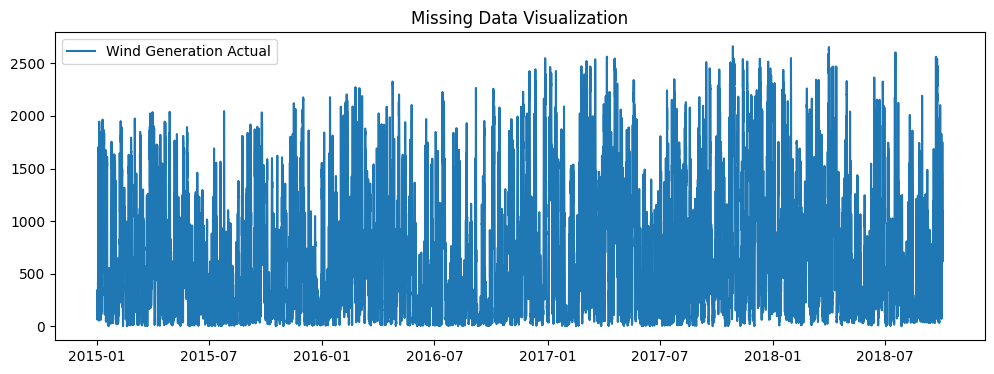

In [134]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.plot(df_selected["AT_wind_onshore_generation_actual"], label="Wind Generation Actual")
plt.title("Missing Data Visualization")
plt.legend()
plt.show()

In [135]:
df_selected["AT_wind_onshore_generation_actual"] = pd.to_numeric(df_selected["AT_wind_onshore_generation_actual"])

df_selected["AT_wind_onshore_generation_actual"] = df_selected["AT_wind_onshore_generation_actual"].interpolate()
print(df_selected["AT_wind_onshore_generation_actual"].isna().sum())

0


## Feature Engineering

### Lagged price (previous hour)

In [136]:
df_selected["AT_price_day_ahead_lag1"] = df_selected["AT_price_day_ahead"].shift(1)

### 24-hour SMA and 24-hour EMA for load

In [137]:
df_selected["AT_load_rolling24h"] = df_selected["AT_load_actual_entsoe_transparency"].rolling(window=24).mean()
df_selected["AT_load_ema24h"] = df_selected["AT_load_actual_entsoe_transparency"].ewm(span=24, adjust=False).mean()

### Hour and weekday

In [138]:
df_selected["hour"] = df_selected.index.hour
df_selected["weekday"] = df_selected.index.dayofweek

In [139]:
df_selected.head(30)

,AT_load_actual_entsoe_transparency,AT_price_day_ahead,AT_wind_onshore_generation_actual,AT_price_day_ahead_lag1,AT_load_rolling24h,AT_load_ema24h,hour,weekday
utc_timestamp,,,,,,,,
2015-01-01 00:00:00+00:00,5946.0,35.0,69.0,NaN,NaN,5946.000000,0,3
2015-01-01 01:00:00+00:00,5726.0,45.0,64.0,35.0,NaN,5928.400000,1,3
2015-01-01 02:00:00+00:00,5347.0,41.0,65.0,45.0,NaN,5881.888000,2,3
2015-01-01 03:00:00+00:00,5249.0,38.0,64.0,41.0,NaN,5831.256960,3,3
2015-01-01 04:00:00+00:00,5309.0,35.0,64.0,38.0,NaN,5789.476403,4,3
2015-01-01 05:00:00+00:00,5574.0,35.0,84.0,35.0,NaN,5772.238291,5,3
2015-01-01 06:00:00+00:00,5925.0,36.0,131.0,35.0,NaN,5784.459228,6,3
2015-01-01 07:00:00+00:00,6343.0,36.0,109.0,36.0,NaN,5829.142489,7,3
2015-01-01 08:00:00+00:00,6882.0,41.0,146.0,36.0,NaN,5913.371090,8,3


In [140]:
df_selected.tail(30)

,AT_load_actual_entsoe_transparency,AT_price_day_ahead,AT_wind_onshore_generation_actual,AT_price_day_ahead_lag1,AT_load_rolling24h,AT_load_ema24h,hour,weekday
utc_timestamp,,,,,,,,
2018-10-01 16:00:00+00:00,8823.0,73.0,1177.0,66.0,7262.375000,7622.682068,16,0
2018-10-01 17:00:00+00:00,8517.0,187.0,1263.0,73.0,7334.416667,7694.227503,17,0
2018-10-01 18:00:00+00:00,7968.0,75.0,1324.0,187.0,7394.208333,7716.129303,18,0
2018-10-01 19:00:00+00:00,7203.0,67.0,1269.0,75.0,7441.291667,7675.078958,19,0
2018-10-01 20:00:00+00:00,6836.0,59.0,1150.0,67.0,7472.333333,7607.952642,20,0
2018-10-01 21:00:00+00:00,6314.0,52.0,1221.0,59.0,7497.708333,7504.436430,21,0
2018-10-01 22:00:00+00:00,6026.0,38.0,1464.0,52.0,7520.208333,7386.161516,22,0
2018-10-01 23:00:00+00:00,5792.0,38.0,1316.0,38.0,7542.375000,7258.628595,23,0
2018-10-02 00:00:00+00:00,5698.0,37.0,1201.0,38.0,7563.250000,7133.778307,0,1


In [141]:
df_model = df_selected.dropna()
df_model.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32822 entries, 2015-01-01 23:00:00+00:00 to 2018-10-02 21:00:00+00:00
Data columns (total 8 columns):
 #   Column                              Non-Null Count  Dtype  
---  ------                              --------------  -----  
 0   AT_load_actual_entsoe_transparency  32822 non-null  float64
 1   AT_price_day_ahead                  32822 non-null  float64
 2   AT_wind_onshore_generation_actual   32822 non-null  float64
 3   AT_price_day_ahead_lag1             32822 non-null  float64
 4   AT_load_rolling24h                  32822 non-null  float64
 5   AT_load_ema24h                      32822 non-null  float64
 6   hour                                32822 non-null  int32  
 7   weekday                             32822 non-null  int32  
dtypes: float64(6), int32(2)
memory usage: 2.0 MB


# Modeling

## Training

### Split the data

In [142]:
split_point = int(len(df_model) * 0.8)
train = df_model.iloc[:split_point]
test = df_model.iloc[split_point:]

### Linear regression

#### Training

In [143]:
from sklearn.linear_model import LinearRegression

X_train = train[["AT_price_day_ahead_lag1", "AT_load_actual_entsoe_transparency", "AT_load_rolling24h", "AT_wind_onshore_generation_actual", "hour", "weekday"]]
y_train = train["AT_price_day_ahead"]
model = LinearRegression()
model.fit(X_train, y_train)

,fit_intercept,True
,copy_X,True
,tol,1e-06
,n_jobs,None
,positive,False


#### Testing

In [144]:
X_test = test[["AT_price_day_ahead_lag1", "AT_load_actual_entsoe_transparency", "AT_load_rolling24h", "AT_wind_onshore_generation_actual", "hour", "weekday"]]
y_test = test["AT_price_day_ahead"]

y_pred = model.predict(X_test) # Test part
y_train_pred = model.predict(X_train) # Train part

#### Calculate error metrics

In [145]:
from sklearn.metrics import mean_absolute_error, root_mean_squared_error

In [146]:
print("MAE:", mean_absolute_error(y_train, y_train_pred)) # Train error
print("RMSE:", root_mean_squared_error(y_train, y_train_pred))

MAE: 2.774551827768339
RMSE: 3.90056853277003


In [147]:
print("MAE:", mean_absolute_error(y_test, y_pred)) # Prediction error
print("RMSE:", root_mean_squared_error(y_test, y_pred))

MAE: 3.25549129365974
RMSE: 4.8022267928895745


In [148]:
print(y_test)

utc_timestamp
2018-01-02 07:00:00+00:00    39.0
2018-01-02 08:00:00+00:00    44.0
2018-01-02 09:00:00+00:00    40.0
2018-01-02 10:00:00+00:00    41.0
2018-01-02 11:00:00+00:00    41.0
                             ... 
2018-10-02 17:00:00+00:00    68.0
2018-10-02 18:00:00+00:00    65.0
2018-10-02 19:00:00+00:00    54.0
2018-10-02 20:00:00+00:00    45.0
2018-10-02 21:00:00+00:00    62.0
Name: AT_price_day_ahead, Length: 6565, dtype: float64


In [149]:
print(y_pred)

[38.01040372 40.84637166 45.3335686  ... 61.0872018  50.31109794
 41.20919478]


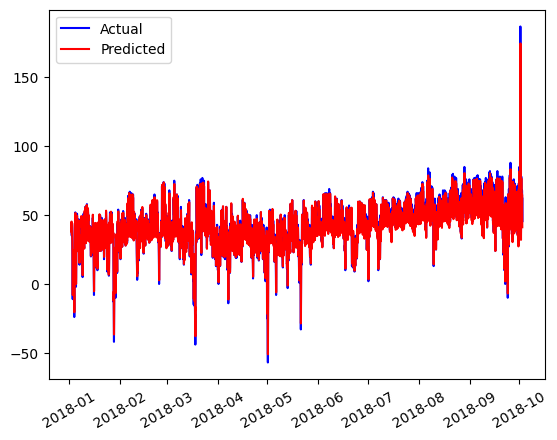

In [150]:
plt.plot(test.index, y_test, label="Actual", color="blue")
plt.plot(test.index, y_pred, label="Predicted", color="red")
plt.xticks(rotation=30)
plt.legend()
plt.show()

### Cross-validation way

In [151]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, make_scorer, root_mean_squared_error

In [152]:
X = df_model[["AT_price_day_ahead_lag1", "AT_load_actual_entsoe_transparency", "AT_load_ema24h", "AT_wind_onshore_generation_actual", "hour", "weekday"]]
y = df_model["AT_price_day_ahead"]

In [153]:
tscv = TimeSeriesSplit(n_splits=5) # Split the data into 5 folds
model = LinearRegression()

In [154]:
scores = cross_val_score(
    model, X, y, cv=tscv,
    scoring=make_scorer(mean_squared_error, greater_is_better=False)
)

In [155]:
import numpy as np
rmse_scores = np.sqrt(-scores)
print("RMSE scores for each fold:", rmse_scores)
print("Mean RMSE:", rmse_scores.mean())
print("Std RMSE:", rmse_scores.std())

RMSE scores for each fold: [3.44707379 3.1366749  4.48398893 4.32078087 4.93825284]
Mean RMSE: 4.0653542672367164
Std RMSE: 0.670397756659311


### Manual CV to plot the most representative fold

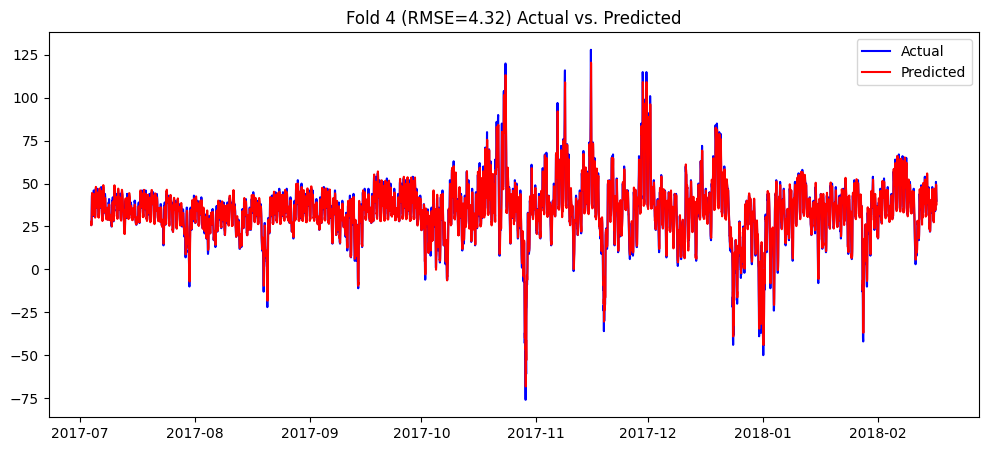

In [156]:
X_cv_plot = df_model[["AT_price_day_ahead_lag1", "AT_load_actual_entsoe_transparency", "AT_load_ema24h", "AT_wind_onshore_generation_actual", "hour", "weekday"]]
y_cv_plot = df_model["AT_price_day_ahead"]

tscv_plot = TimeSeriesSplit(n_splits=5)
model_cv_plot = LinearRegression()

fold_rmse = []
fold_preds = []
fold_indices = []

for train_idx, test_idx in tscv_plot.split(X_cv_plot):
    model_cv_plot.fit(X_cv_plot.iloc[train_idx], y_cv_plot.iloc[train_idx])
    y_pred_fold = model_cv_plot.predict(X.iloc[test_idx])
    rmse = root_mean_squared_error(y_cv_plot.iloc[test_idx], y_pred_fold)
    fold_rmse.append(rmse)
    fold_preds.append(y_pred_fold)
    fold_indices.append(test_idx)

mean_rmse = np.mean(fold_rmse)
best_fold = np.argmin(np.abs(np.array(fold_rmse) - mean_rmse))

plt.figure(figsize=(12, 5))
plt.plot(y_cv_plot.iloc[fold_indices[best_fold]].index, y.iloc[fold_indices[best_fold]], label="Actual", color="blue")
plt.plot(y_cv_plot.iloc[fold_indices[best_fold]].index, fold_preds[best_fold], label="Predicted", color="red")
plt.title(f"Fold {best_fold+1} (RMSE={fold_rmse[best_fold]:.2f}) Actual vs. Predicted")
plt.legend()
plt.show()

### Coefficients

#### Raw Coefficients

In [157]:
for feature, coeff in zip(["AT_price_day_ahead_lag1", "AT_load_actual_entsoe_transparency", "AT_load_ema24h", "AT_wind_onshore_generation_actual", "hour", "weekday"], model_cv_plot.coef_):
    print(f"{feature}: {coeff}")

AT_price_day_ahead_lag1: 0.9252642296534156
AT_load_actual_entsoe_transparency: 0.00148447979339983
AT_load_ema24h: -0.0012850055699675069
AT_wind_onshore_generation_actual: -0.0001230859300456718
hour: -0.12249617207266901
weekday: 0.028069213027160502


#### Normalized Coefficients

In [158]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

model = LinearRegression()
model.fit(X_train_scaled, y_train)

for feature, coeff in zip(X_train.columns, model.coef_):
    print(f"{feature}: {coeff}")

AT_price_day_ahead_lag1: 12.823294761126467
AT_load_actual_entsoe_transparency: 1.696579052463579
AT_load_rolling24h: -0.7458099051035761
AT_wind_onshore_generation_actual: -0.10571853512554606
hour: -1.0363762106252374
weekday: 0.05922149419434316
